# Imports

In [1]:
import os

from matplotlib import pyplot as plt
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from src.models import Unet
from src.utils import (
    get_data,
    get_device,
    get_truth_vs_predicted,
    load,
    loss,
    plot_image_and_prediction,
    predict_image,
    predict_patch,
    seed_everyting,
    test,
    train,
)

# Global parameters

In [2]:
image_size = 256
img_dir = "data/images"
model_dir = "models"
patch_dir = "data/patches"
results_dir = "results"
gedi_dir = "data/gedi"
random_state = 42
batch_size = 12
num_workers = os.cpu_count() // 2
learning_rate = 1e-2
epochs = 25
is_training = False
bins = list(range(0, 55, 5))
device = get_device()

seed_everyting(random_state)

Using mps device


# Create dataloaders

In [3]:
# Create dataloaders
train_dl, val_dl, test_dl = get_data(
    img_dir, patch_dir, gedi_dir, image_size, batch_size, num_workers, bins
)

INFO:root:Starting preprocessing...
INFO:root:Directories validated.
INFO:root:Images loaded.
INFO:root:Number of images: 48
INFO:root:GEDI data loaded.
INFO:root:Loaded existing patch info file. Skipping image processing.
INFO:root:Number of patches: 9234
INFO:root:Number of labels: 629074


# Create & Train model

In [4]:
if is_training:
    model = Unet().to(device)

    # Create optimizer
    optimizer = SGD(model.parameters(), learning_rate)

    # Create scheduler
    scheduler = CosineAnnealingLR(optimizer, epochs)

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        train(train_dl, model, loss, device, optimizer, scheduler)
        test(val_dl, model, loss, device)

    print("Training finished.")

    test(test_dl, model, loss, device)
else:
    model = load(
        os.path.join(model_dir, "unet", f"u-efficientnet-b4-e{epochs}.pt"),
        device,
    )

In [5]:
# save(model, os.path.join(model_dir, f"{model.name}.pt"))

# Visualise results

In [6]:
inputs, targets = next(iter(test_dl))

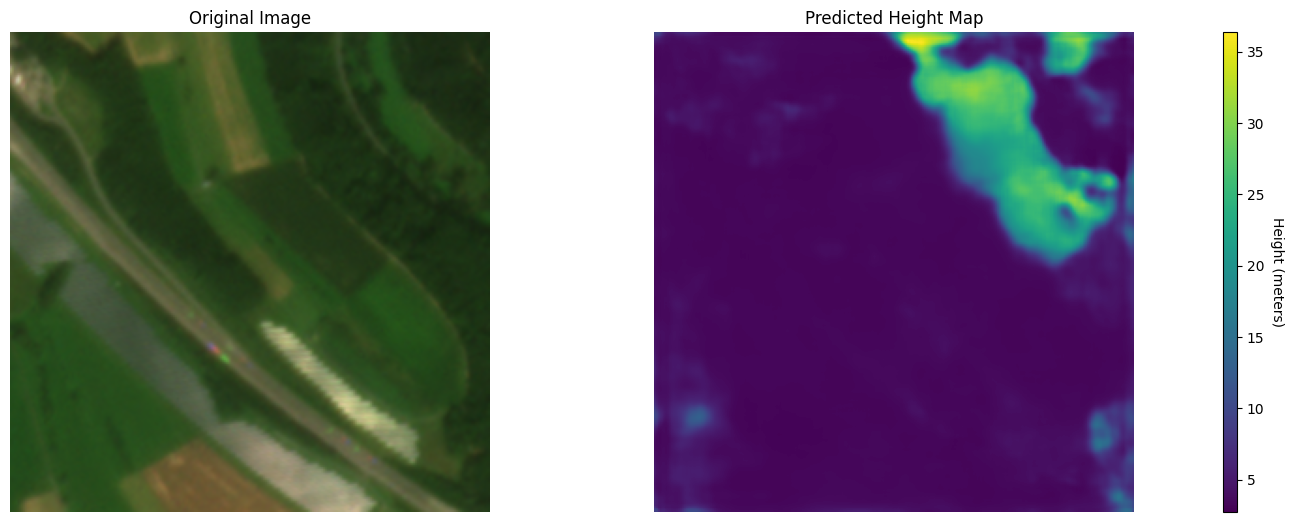

In [19]:
idx = 3
patch = inputs[idx], None
img, pred = predict_patch(model, patch, device)
plot_image_and_prediction(img, pred)

In [9]:
image, prediction = predict_image(
    model, device, f"{img_dir}/L15-1059E-1348N.tif", image_size
)

100%|██████████| 256/256 [00:14<00:00, 17.79it/s]


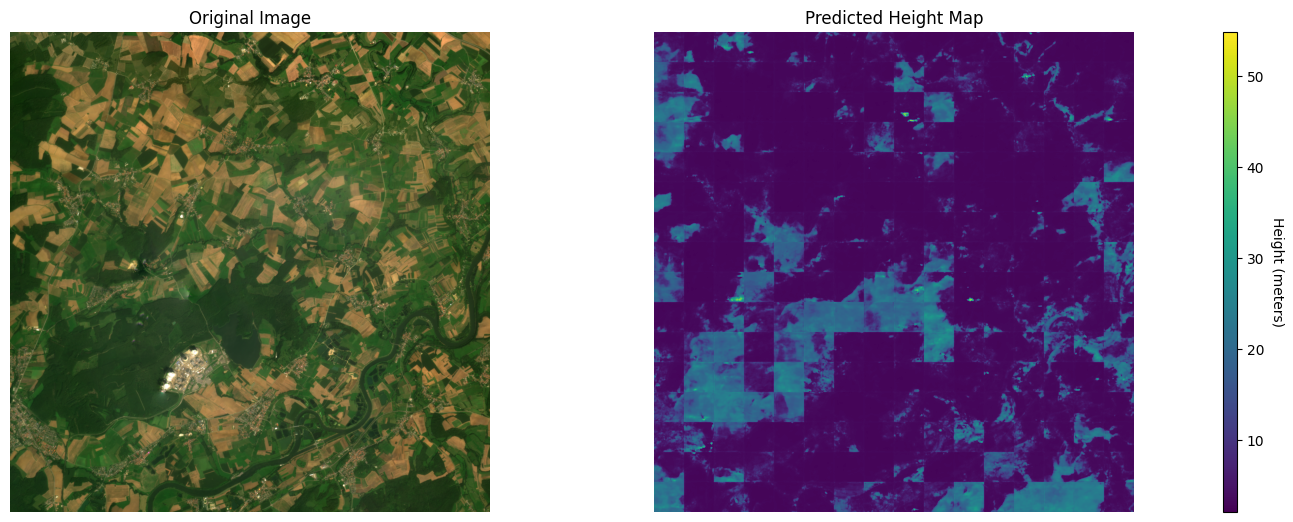

In [10]:
plot_image_and_prediction(image, prediction)

In [11]:
truth, predicted = get_truth_vs_predicted(model, test_dl, device)

  0%|          | 0/8 [00:00<?, ?it/s]loc("mps_not_equal"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":253:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W1572864 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W1572864 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
 88%|████████▊ | 7/8 [00:17<00:00,  1.17it/s]loc("mps_not_equa

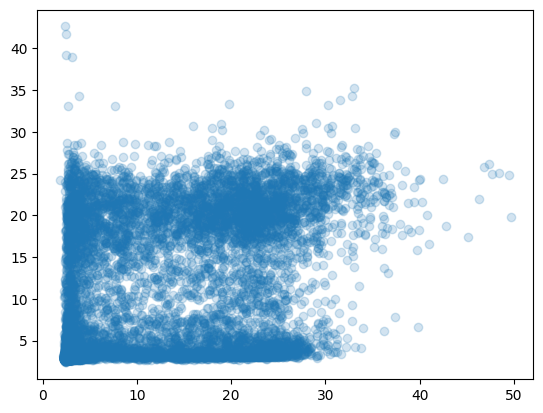

In [12]:
mask = (truth > 0) & (truth < 50)

plt.scatter(truth[mask], predicted[mask], alpha=0.2)

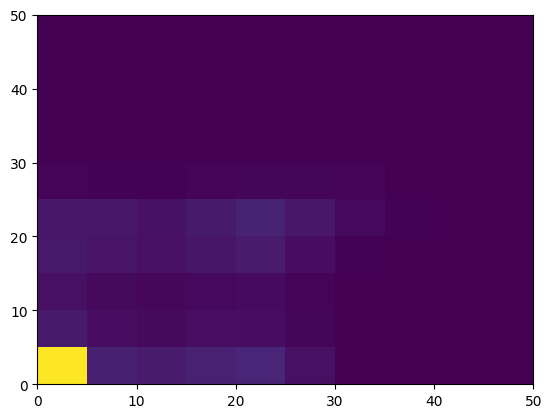

In [13]:
plt.hist2d(truth[mask], predicted[mask], bins)[-1]